# Training with Background Data

## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

In [1]:
! pip install timm
import timm

In [2]:
import torch, time, os, copy, random, imageio, os, shutil, numpy, zipfile
import matplotlib.pyplot as plt, pandas as pd, seaborn as sn, torch.nn as nn
from torchvision import datasets, models, transforms, utils
from sklearn.metrics import confusion_matrix
from zipfile import ZipFile

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
Num_class=101
folderlocation = './data/'
def create_dir(folderlocation):
    if not os.path.exists(folderlocation):
        os.mkdir(folderlocation)

shutil.copytree('/kaggle/input/caltech101/Caltech101/Caltech101', folderlocation)

'./data/'

### Create Directories and Extract Background Data

In [4]:
for iterf in ['train/', 'eval/']:
    create_dir(folderlocation + iterf + 'zzzBackground') 

create_dir('./Background/')
with zipfile.ZipFile('/kaggle/input/background-image-data/Background_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./Background/')

In [5]:
count = 0
for root_dir, cur_dir, files in os.walk(folderlocation+'train/'):
    count += len(files)
print('Image count without Background Class:', count)

Image count without Background Class: 6162


### Copy Background Data to train and validation folders

In [6]:
image_index = 0
for dirpath, dirnames, filenames in os.walk('./Background/'):
    for fname in filenames:
        if image_index == 2000: 
            shutil.copyfile(path, folderlocation + 'eval/'+'zzzBackground'+'/'+str(image_index) + fname[-9:])
            #break 
        path = os.path.join(dirpath,fname)
        shutil.copyfile(path, folderlocation + 'train/'+'zzzBackground'+'/'+str(image_index) + fname[-9:])
        image_index = image_index +1

In [7]:
count = 0
for root_dir, cur_dir, files in os.walk(folderlocation+'train/'):
    count += len(files)
print('Image count with Background Class:', count)

Image count with Background Class: 9163


### Dataloaders

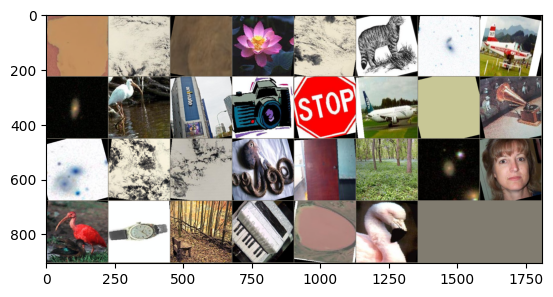

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

im_dimention = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'eval','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'eval']}

dataloaders_test = {'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=30,
                                             shuffle=False, num_workers=0)}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.507, 0.487, 0.441])
    std = numpy.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

### Model and Training functions

In [9]:
model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class+1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
          
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Training

In [10]:
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3) 

Epoch 0/2
----------
train Loss: 0.5103 Acc: 0.8979
eval Loss: 0.1263 Acc: 0.9610

Epoch 1/2
----------
train Loss: 0.0331 Acc: 0.9915
eval Loss: 0.0922 Acc: 0.9756

Epoch 2/2
----------
train Loss: 0.0173 Acc: 0.9950
eval Loss: 0.0871 Acc: 0.9720

Training complete in 28m 33s
Best val Acc: 0.975639


### Test

In [11]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders_test['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output = output[:,0:Num_class] # Discarding Background Class
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        
test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

Test Accuracy: 0.9811209439528024


### Save Model

In [12]:
PATH = "./model_background.pt"
torch.save(model_ft.state_dict(), PATH)

'''
#Guideline for loading model in future 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.wide_resnet101_2(pretrained=False) 
        #We only need the structure to transfer parameters
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load(PATH2, map_location=device))
'''

'\n#Guideline for loading model in future \ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = models.wide_resnet101_2(pretrained=False) \n        #We only need the structure to transfer parameters\n        \nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, Num_class)\n\nmodel.load_state_dict(torch.load(PATH2, map_location=device))\n'

### Delete Downloaded Data

In [13]:
shutil.rmtree('./Background/')
shutil.rmtree('./data/')